**1- KÜTÜPHANELER**

In [21]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

pd.set_option("display.max_columns", None)

**2- FEATURE ENGINEERING**

In [3]:
def feature_engineering(df):
    df = df.copy()

    # 1. Missing value features
    df["missing_count"] = df.isna().sum(axis=1)
    df["missing_ratio"] = df.isna().mean(axis=1)

    # 2. Text features
    text_cols = [c for c in df.columns if "description" in c or "name" in c]
    for col in text_cols:
        df[col] = df[col].astype(str)
        df[col+"_word_count"] = df[col].apply(lambda x: len(x.split()))
        df[col+"_char_len"] = df[col].apply(len)

    # 3. Numeric interactions
    if "bedrooms" in df.columns and "bathrooms" in df.columns:
        df["bed_bath_ratio"] = df["bedrooms"] / (df["bathrooms"]+1)

    if "accommodates" in df.columns and "price" in df.columns:
        df["price_per_person"] = df["price"] / (df["accommodates"]+1)

    # 4. Availability stats
    avail_cols = [c for c in df.columns if "availability" in c]
    if len(avail_cols) > 0:
        df["availability_mean"] = df[avail_cols].mean(axis=1)
        df["availability_std"]  = df[avail_cols].std(axis=1)

    # 5. Reviews / price
    if "number_of_reviews" in df.columns and "price" in df.columns:
        df["reviews_per_price"] = df["number_of_reviews"] / (df["price"]+1)

    # 6. Boolean → int
    bool_cols = df.select_dtypes(include="bool").columns
    for col in bool_cols:
        df[col] = df[col].astype(int)

    return df

**3- DATA LOAD + FEATURE ENGINEERING**

In [4]:
train_path = r"C:\Users\lelas\datamining\Airbnb-Price_Predection\processed_data\train_unscaled.csv"
val_path   = r"C:\Users\lelas\datamining\Airbnb-Price_Predection\processed_data\val_unscaled.csv"
test_path  = r"C:\Users\lelas\datamining\Airbnb-Price_Predection\processed_data\test_unscaled.csv"

train = pd.read_csv(train_path)
val   = pd.read_csv(val_path)
test  = pd.read_csv(test_path)

train = feature_engineering(train)
val   = feature_engineering(val)
test  = feature_engineering(test)

target_col = "price"

X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_val = val.drop(columns=[target_col])
y_val = val[target_col]

X_test = test.drop(columns=[target_col])
y_test = test[target_col]

print("Shapes after FE:", X_train.shape, X_val.shape, X_test.shape)

Shapes after FE: (12016, 119) (4006, 119) (4006, 119)


**4- DATA VISUALIZATION**

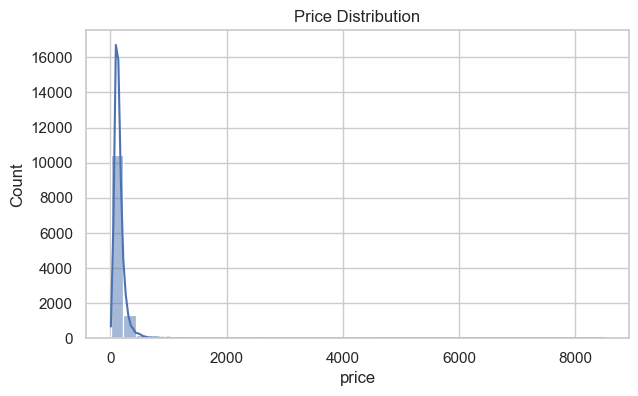

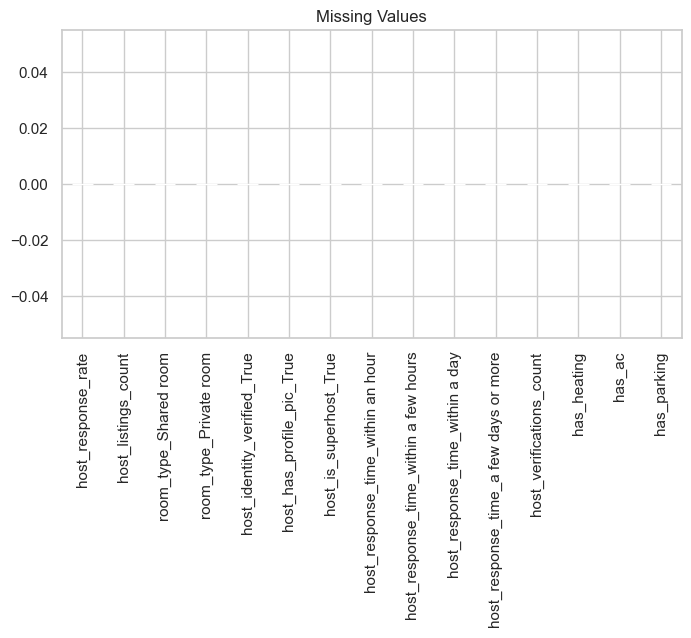

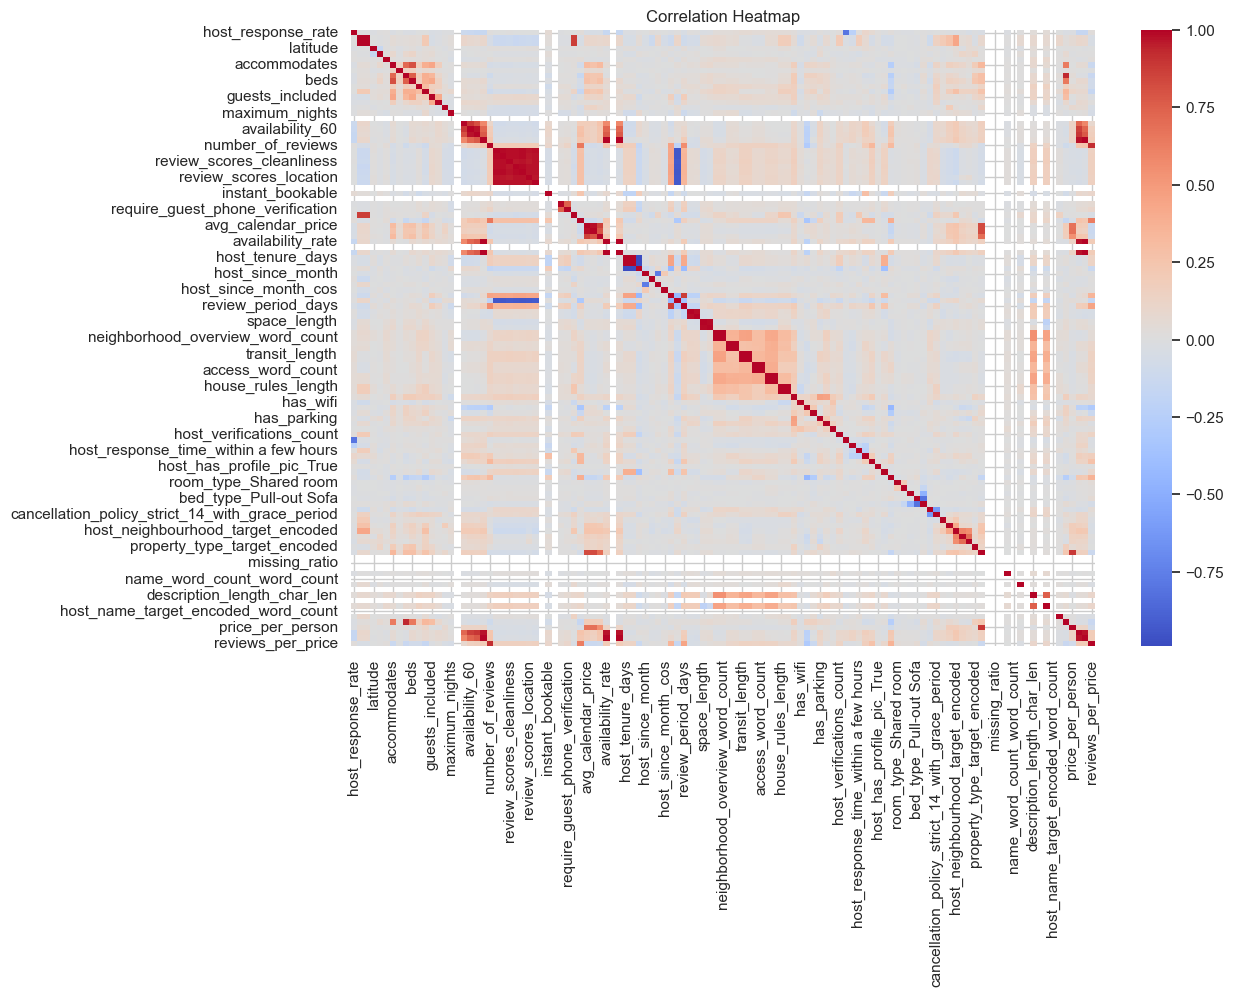

In [5]:
plt.figure(figsize=(7,4))
sns.histplot(y_train, bins=40, kde=True)
plt.title("Price Distribution")
plt.show()

plt.figure(figsize=(8,4))
train.isna().sum().sort_values(ascending=False)[:15].plot(kind="bar")
plt.title("Missing Values")
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(train.select_dtypes(include=np.number).corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

**5- SCALING**

In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

**6- TREE-BASED FEATURE SELECTION**

In [22]:
fs_model = ExtraTreesRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
fs_model.fit(X_train_scaled, y_train)

selector = SelectFromModel(fs_model, prefit=True, threshold="median")

X_train_fs = selector.transform(X_train_scaled)
X_val_fs   = selector.transform(X_val_scaled)
X_test_fs  = selector.transform(X_test_scaled)

print("Tree-based FS output:", X_train_fs.shape)

Tree-based FS output: (12016, 60)


**7- PCA**

In [23]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_fs)
X_val_pca   = pca.transform(X_val_fs)
X_test_pca  = pca.transform(X_test_fs)

print("PCA components:", X_train_pca.shape[1])

PCA components: 35


**8- EVALUATION FUNCTIONS**

In [24]:
def evaluate(model, X_train, y_train, X_val=None, y_val=None, title="MODEL"):
    print(f"\n=== {title} RESULTS ===")

    # ---------- TRAIN ----------
    preds_train = model.predict(X_train)
    rmse_train  = np.sqrt(mean_squared_error(y_train, preds_train))
    mae_train   = mean_absolute_error(y_train, preds_train)
    r2_train    = r2_score(y_train, preds_train)

    print("\n--- TRAIN ---")
    print(f"RMSE: {rmse_train:.2f}")
    print(f"MAE : {mae_train:.2f}")
    print(f"R²  : {r2_train:.4f}")

    if X_val is None or y_val is None:
        return {
            "train": (rmse_train, mae_train, r2_train)
        }

    # ---------- VAL ----------
    preds_val = model.predict(X_val)
    rmse_val  = np.sqrt(mean_squared_error(y_val, preds_val))
    mae_val   = mean_absolute_error(y_val, preds_val)
    r2_val    = r2_score(y_val, preds_val)

    print("\n--- VAL ---")
    print(f"RMSE: {rmse_val:.2f}")
    print(f"MAE : {mae_val:.2f}")
    print(f"R²  : {r2_val:.4f}")

    return {
        "train": (rmse_train, mae_train, r2_train),
        "val":   (rmse_val,  mae_val,  r2_val)
    }

def assess_silent(model, X, y):
    preds = model.predict(X)
    return (
        np.sqrt(mean_squared_error(y, preds)),
        mean_absolute_error(y, preds),
        r2_score(y, preds)
    )

**9- MODEL 1: ExtraTrees**

In [25]:
from sklearn.ensemble import ExtraTreesRegressor
import joblib

et = ExtraTreesRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

et.fit(X_train, y_train)
evaluate(et, X_train, y_train, X_val, y_val, "ET")

model_path = "extra_trees_model.pkl"
joblib.dump(et, model_path)

et_loaded = joblib.load(model_path)
evaluate(et_loaded, X_test, y_test, None, None, "ET TEST")


=== ET RESULTS ===

--- TRAIN ---
RMSE: 0.00
MAE : 0.00
R²  : 1.0000

--- VAL ---
RMSE: 29.38
MAE : 2.41
R²  : 0.9634

=== ET TEST RESULTS ===

--- TRAIN ---
RMSE: 13.86
MAE : 2.13
R²  : 0.9802


{'train': (13.860466693898369, 2.1255117324013977, 0.9801959072985095)}

**10- MODEL 2: SVR**

In [26]:
from sklearn.svm import SVR

svr = SVR(
    kernel="rbf",
    C=10,
    gamma=0.05,
    epsilon=0.1
)

svr.fit(X_train_pca, y_train)

evaluate(svr, X_train_pca, y_train, X_val_pca, y_val, "SVR")
evaluate(svr, X_test_pca,  y_test, None, None, "SVR TEST")


=== SVR RESULTS ===

--- TRAIN ---
RMSE: 142.22
MAE : 32.72
R²  : 0.1691

--- VAL ---
RMSE: 143.26
MAE : 38.62
R²  : 0.1296

=== SVR TEST RESULTS ===

--- TRAIN ---
RMSE: 79.40
MAE : 37.81
R²  : 0.3501


{'train': (79.40260899662977, 37.810847440396955, 0.3500667006269219)}

**11- MODEL 3: KNN**

In [27]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(
    n_neighbors=7,
    weights='distance',
    p=2
)

knn.fit(X_train_pca, y_train)

evaluate(knn, X_train_pca, y_train, X_val_pca, y_val, "KNN")
evaluate(knn, X_test_pca,  y_test, None, None, "KNN TEST")


=== KNN RESULTS ===

--- TRAIN ---
RMSE: 0.00
MAE : 0.00
R²  : 1.0000

--- VAL ---
RMSE: 78.57
MAE : 39.42
R²  : 0.7382

=== KNN TEST RESULTS ===

--- TRAIN ---
RMSE: 62.17
MAE : 38.95
R²  : 0.6016


{'train': (62.1677327165222, 38.94692763407665, 0.6015908528753984)}

**12- SUMMARY TABLE**

In [28]:
summary = pd.DataFrame({
    "Model": ["ExtraTrees", "SVR", "KNN"],
    "Val_R2": [
        assess_silent(et,  X_val,     y_val)[2],  
        assess_silent(svr, X_val_pca, y_val)[2],  
        assess_silent(knn, X_val_pca, y_val)[2],   
    ],
    "Test_R2": [
        assess_silent(et,  X_test,     y_test)[2], 
        assess_silent(svr, X_test_pca, y_test)[2],
        assess_silent(knn, X_test_pca, y_test)[2], 
    ]
})

summary

,Model,Val_R2,Test_R2
0,ExtraTrees,0.963387,0.980196
1,SVR,0.129592,0.350067
2,KNN,0.738172,0.601591
